# Household Electricity Forecasting

Midterm project notebook covering data prep and exploratory analysis for the UCI Individual household electric power consumption dataset.

## Objectives
- Load and clean the raw minute-level power measurements (2006-2010).
- Aggregate to daily consumption targets suitable for next-day forecasting.
- Explore seasonal patterns, trends, and relationships among sub-meter readings.
- Produce baseline metrics that will guide subsequent modeling notebooks/scripts.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

PROJECT_ROOT = Path().resolve().parent
DATA_PATH = PROJECT_ROOT / 'data/household_power_consumption.txt'
DATA_PATH.exists()

True

### Load raw dataset
The file is semicolon-delimited with decimal points and `?` for missing values.

In [2]:
dtype_spec = {
    'Date': 'string',
    'Time': 'string',
    'Global_active_power': 'string',
    'Global_reactive_power': 'string',
    'Voltage': 'string',
    'Global_intensity': 'string',
    'Sub_metering_1': 'string',
    'Sub_metering_2': 'string',
    'Sub_metering_3': 'string'
}

df = pd.read_csv(
    DATA_PATH,
    sep=';',
    dtype=dtype_spec,
    na_values='?',
    parse_dates={'timestamp': ['Date', 'Time']},
    dayfirst=True,
    low_memory=False
)

df.head()

C:\Users\OluwapemiAdekanmi\AppData\Local\Temp\ipykernel_17928\2877540298.py:13: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


,timestamp,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.000
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.000
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.000
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.000
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.000


### Basic cleaning
Convert numeric columns and drop rows with missing target values.

In [3]:
numeric_cols = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

df[numeric_cols] = df[numeric_cols].astype(float)
df = df.dropna(subset=['Global_active_power']).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp              datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 125.1 MB


## Time indexing and quality checks
We'll sort by timestamp, set it as the index, and inspect duplicate or missing readings before engineering aggregates.


In [4]:
df = df.sort_values('timestamp').set_index('timestamp')
df = df[~df.index.duplicated(keep='first')]

summary = {
    'start': df.index.min(),
    'end': df.index.max(),
    'n_rows': len(df),
    'freq_minutes': df.index.to_series().diff().dt.total_seconds().value_counts().head()
}
summary


{'start': Timestamp('2006-12-16 17:24:00'),
 'end': Timestamp('2010-11-26 21:02:00'),
 'n_rows': 2049280,
 'freq_minutes': timestamp
 60.0      2049208
 120.0          38
 180.0          14
 240.0           2
 2340.0          1
 Name: count, dtype: int64}

### Missingness snapshot
Compute the share of missing values per feature after initial cleaning.


In [5]:
missing_share = df.isna().mean().sort_values(ascending=False)
missing_share


Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
dtype: float64

## Energy aggregation
Convert active power readings (kW) into energy (kWh) per minute, then resample to hourly and daily totals for forecasting targets.


In [6]:
df['energy_kwh'] = df['Global_active_power'] / 60.0
hourly_energy = df['energy_kwh'].resample('H').sum().to_frame(name='kwh')
daily_energy = df['energy_kwh'].resample('D').sum().to_frame(name='kwh')

hourly_energy.describe().round(3)


C:\Users\OluwapemiAdekanmi\AppData\Local\Temp\ipykernel_17928\1600871679.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_energy = df['energy_kwh'].resample('H').sum().to_frame(name='kwh')


,kwh
count,34589.000
mean,1.078
std,0.900
min,0.000
25%,0.337
50%,0.782
75%,1.570
max,6.561


In [7]:
daily_energy.describe().round(3)


,kwh
count,1442.000
mean,25.856
std,10.288
min,0.000
25%,19.353
50%,25.580
75%,31.498
max,79.556


### Daily consumption trend
Visualize overall consumption trajectory to highlight seasonality and outliers.


c:\Users\OluwapemiAdekanmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\OluwapemiAdekanmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


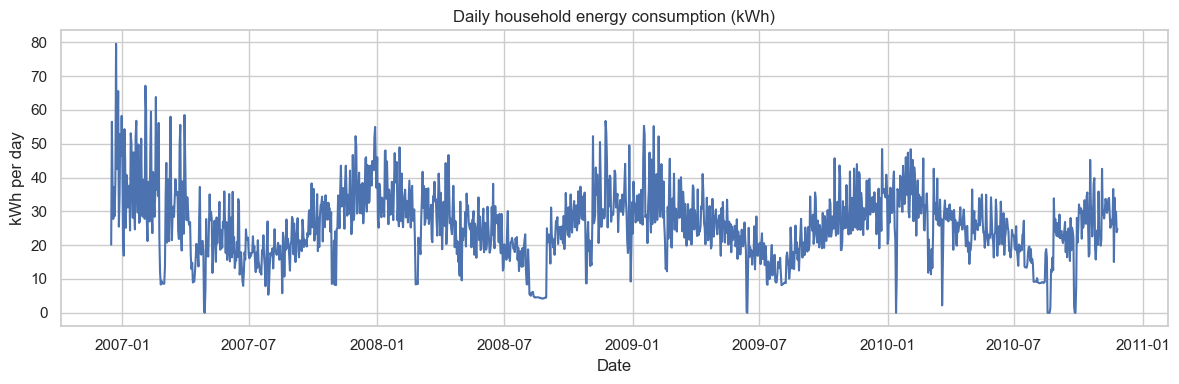

In [8]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=daily_energy, x=daily_energy.index, y='kwh')
plt.title('Daily household energy consumption (kWh)')
plt.xlabel('Date')
plt.ylabel('kWh per day')
plt.tight_layout()
plt.show()


### Weekday patterns
Summaries by day-of-week offer guidance for covariates capturing weekly seasonality.


In [9]:
daily_energy = daily_energy.assign(
    weekday=lambda x: x.index.day_name(),
    month=lambda x: x.index.month
)

weekday_profile = (daily_energy
                   .groupby('weekday')['kwh']
                   .agg(['count', 'mean', 'std'])
                   .sort_values('mean', ascending=False))
weekday_profile


,count,mean,std
weekday,,,
Saturday,206,29.170542,12.898678
Sunday,206,28.631866,12.319406
Wednesday,206,25.721006,9.403564
Tuesday,206,25.509776,9.402348
Friday,206,24.904109,8.396871
Monday,206,23.764936,8.615551
Thursday,206,23.286832,8.571520


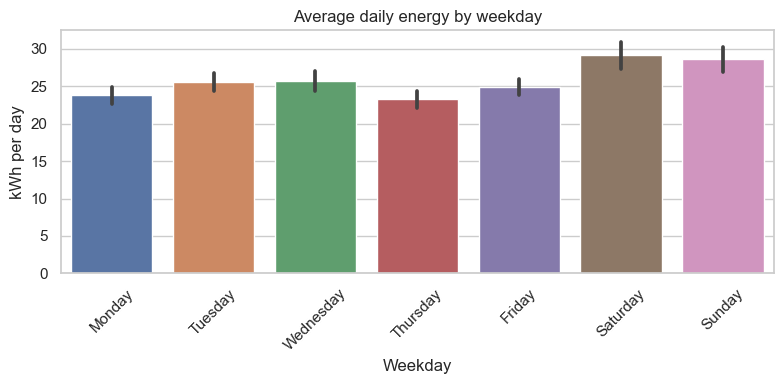

In [10]:
plt.figure(figsize=(8, 4))
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.barplot(data=daily_energy, x='weekday', y='kwh', order=order, estimator=np.mean)
plt.title('Average daily energy by weekday')
plt.ylabel('kWh per day')
plt.xlabel('Weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Monthly seasonality
Quick aggregation by calendar month to see heating vs cooling demand shifts.


In [11]:
monthly_profile = (daily_energy
                   .groupby('month')['kwh']
                   .agg(['mean', 'std', 'count'])
                   .round(2))
monthly_profile


,mean,std,count
month,,,
1,34.48,9.47,124
2,31.20,11.76,113
3,29.22,9.07,124
4,24.59,8.09,120
5,24.71,5.22,124
6,21.40,6.50,120
7,16.80,4.50,124
8,13.12,7.33,124
9,22.71,5.82,120


C:\Users\OluwapemiAdekanmi\AppData\Local\Temp\ipykernel_17928\437295172.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=daily_energy, x='month', y='kwh', estimator=np.mean, ci='sd')
c:\Users\OluwapemiAdekanmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\OluwapemiAdekanmi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


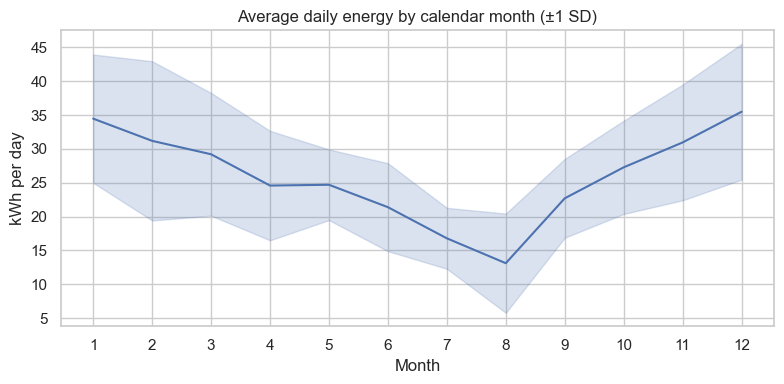

In [12]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=daily_energy, x='month', y='kwh', estimator=np.mean, ci='sd')
plt.title('Average daily energy by calendar month (±1 SD)')
plt.xlabel('Month')
plt.ylabel('kWh per day')
plt.xticks(ticks=range(1,13))
plt.tight_layout()
plt.show()


## Notes & next steps
- Minute-level data is nearly gap-free; we can safely aggregate to hourly/daily horizons.
- Daily demand shows strong weekly and seasonal variation, so adding weekday/month features (or Fourier terms) should help.
- Next notebook: derive lag/rolling features, split train/validation chronologically, and benchmark forecasting models.
